In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib
from utils import download_datasets

In [2]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')


datasets_cities = [
    'seattle',
    'boston',
    'austin'
]

datasets_cities = ['seattle', 'boston', 'austin']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: austin_reviews.csv.gz, in cache


In [3]:
#Reading files


listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz', index_col=0)]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## Basics stats
print("Count of listings")
print(listings.count()[0])
print("Calendar has every listing?")
print(listings.count()[0] == calendar.groupby("listing_id").all().count()[0])


Count of listings
25970
Calendar has every listing?
True


In [5]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [6]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6196350900142947


In [7]:
#
def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.min()/x.price.max()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

def std_metric(data):
    return data.price.std()
    
def mean_metric(data):
    return data.price.mean()

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))
std = calendar.groupby('listing_id').apply(lambda x: std_metric(x))
mean = calendar.groupby('listing_id').apply(lambda x: mean_metric(x))

,min_max,variation,available,std,mean
id,,,,,
2265,0.727273,4.0,0.298630,24.300003,209.862385
2318,0.592000,6.0,0.901370,55.673626,319.106383
3781,0.833333,25.0,0.246575,11.260312,131.944444
4291,1.000000,0.0,0.953425,0.000000,82.000000
5245,0.714286,2.0,0.400000,13.780107,129.109589
5456,0.271429,58.0,0.884932,64.182727,134.272446
5506,0.580000,3.0,0.841096,13.312418,146.723127
5682,0.684211,8.0,0.060274,5.439355,55.590909
5769,0.909091,10.0,0.178082,1.074843,40.430769


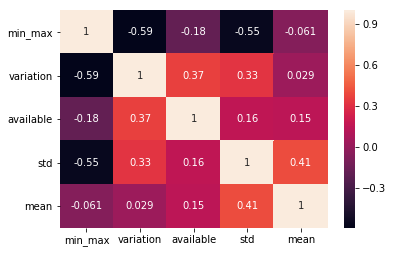

In [8]:
min_max.name = "min_max"
variation.name = "variation"
available.name = "available"
std.name = "std"
mean.name = "mean"

combined_metrics = pd.concat([min_max, variation, available, std, mean], axis=1).dropna()
sns.heatmap(combined_metrics.corr(), annot=True);
combined_metrics.index.name = "id"
display(combined_metrics)

In [9]:
listings_merged = pd.merge(combined_metrics, listings, on='id')

In [10]:
corr_matrix = listings_merged.corr()
corr_matrix.style.background_gradient()

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,min_max,variation,available,std,mean,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
min_max,1,-0.590184,-0.182885,-0.554707,-0.0606116,0.0909683,nan,nan,nan,-0.0308548,nan,-0.327463,-0.327463,0.130008,-0.0797952,-0.244826,-0.0742566,-0.118262,-0.198674,0.175817,-0.204318,0.102989,-0.00457111,-0.131042,-0.155632,-0.167402,-0.182885,-0.11861,0.0621011,0.0481651,-0.0452254,0.0676414,0.0611305,-0.0630056,0.0809727,-0.279455,-0.133159
variation,-0.590184,1,0.371571,0.325668,0.0288452,-0.0366476,nan,nan,nan,0.0463471,nan,0.305274,0.305274,-0.0221614,-0.0241222,0.163339,0.038526,0.0730043,0.131654,-0.147358,0.160131,-0.0648096,0.000806489,0.114857,0.168822,0.206188,0.371571,0.0742349,-0.0932376,-0.0850092,0.0110598,-0.101164,-0.0846628,0.0153371,-0.100725,0.250376,0.07078
available,-0.182885,0.371571,1,0.158907,0.14698,-0.112908,nan,nan,nan,-0.0428978,nan,0.0631671,0.0631671,-0.136897,0.0538621,0.122115,0.123731,0.109745,0.119221,0.247507,0.101099,0.0860368,-0.00121166,0.329901,0.410294,0.469719,1,-0.00941671,-0.0562422,-0.0652269,-0.0328957,-0.0401181,-0.062394,-0.0354811,-0.0787811,-0.00657005,-0.166246
std,-0.554707,0.325668,0.158907,1,0.405864,-0.109483,nan,nan,nan,0.0524522,nan,0.175844,0.175844,-0.156505,0.0964186,0.45769,0.341022,0.374871,0.430203,0.279052,0.376059,-0.00705613,0.00189609,0.125882,0.119097,0.112756,0.158907,-0.0301125,-0.0162579,-0.0324981,0.023242,-0.0338338,-0.0444934,0.038132,-0.0690963,0.157556,-0.0378512
mean,-0.0606116,0.0288452,0.14698,0.405864,1,-0.122927,nan,nan,nan,0.0112338,nan,0.0799527,0.0799527,-0.156618,0.0728731,0.503,0.534496,0.511101,0.456707,0.544958,0.33648,0.00471849,-0.00133845,0.18811,0.163431,0.141365,0.14698,-0.128399,0.0343253,-0.0120589,0.0354463,-0.0203862,-0.032909,0.0542247,-0.0660998,0.100283,-0.181673
scrape_id,0.0909683,-0.0366476,-0.112908,-0.109483,-0.122927,1,nan,nan,nan,0.00087162,nan,0.194907,0.194907,0.850943,0.196992,-0.201459,-0.177613,-0.1981,-0.173511,-0.333746,-0.177669,0.0013752,-0.00781124,-0.333131,-0.256528,-0.207727,-0.112908,0.0827789,-0.183219,-0.119394,-0.0833189,-0.0969617,-0.111659,-0.0939947,-0.168401,0.237207,0.154548
thumbnail_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
medium_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
xl_picture_url,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_id,-0.0308548,0.0463471,-0.0428978,0.0524522,0.0112338,0.00087162,nan,nan,nan,1,nan,-0.0855426,-0.0855426,-0.022954,0.0446522,0.0470982,0.0295961,0.0236318,0.0492188,-0.197672,0.07092,-0.0327081,-0.00645961,0.00828125,0.0206801,0.0225303,-0.0428978,-0.201837,-0.0261485,-0.0246,-0.0224593,-0.0260386,-0.0322776,-0.0101916,-0.0159027,-0.106839,0.149761


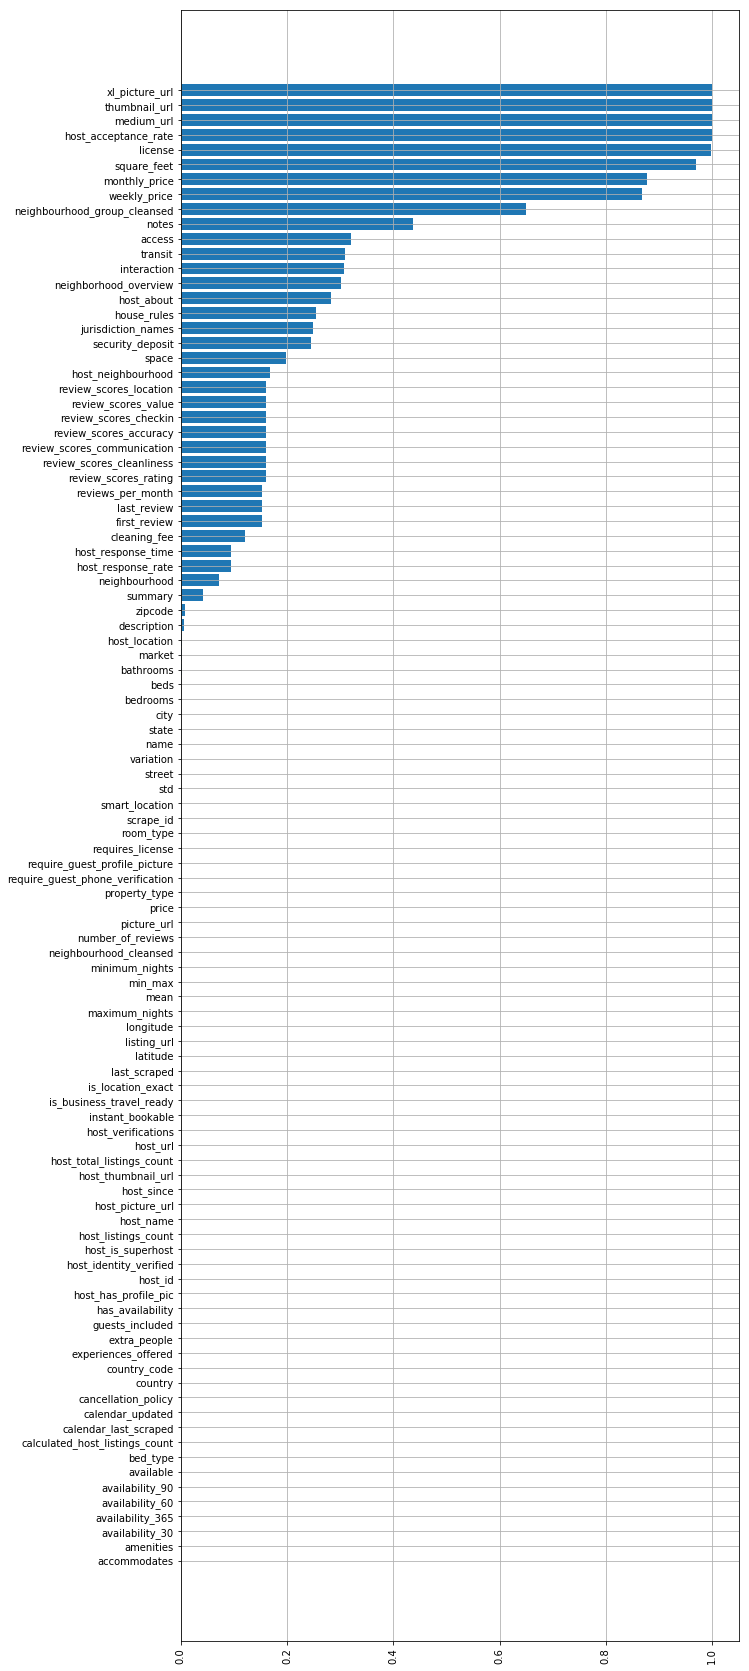

In [11]:
#Getting null % for each feature

labels_ = []
values_ = []

for feature in listings_merged.columns:
    nulls_percentage = listings_merged[feature].isna().mean()
    labels_ += [feature]
    values_ += [nulls_percentage]
    
values_, labels_ = zip(*sorted(zip(values_, labels_)))

plt.figure(1, figsize=(10, 30))
plt.xticks(rotation='vertical')
plt.grid(True)
plt.barh(labels_, values_)
plt.show();

In [12]:
remove_from = 0.6
to_remove = []
for feature in listings_merged.columns:
    nulls_percentage = listings_merged[feature].isna().mean()
    if nulls_percentage >= remove_from:
        to_remove += [feature]
listings_droped_cols = listings_merged.drop(to_remove, axis=1)

In [13]:
for col in listings_droped_cols.select_dtypes(include=np.object):
    display(listings_droped_cols[col].sample(10))


id
13157632    https://www.airbnb.com/rooms/13157632
23338231    https://www.airbnb.com/rooms/23338231
11567761    https://www.airbnb.com/rooms/11567761
27439451    https://www.airbnb.com/rooms/27439451
17386455    https://www.airbnb.com/rooms/17386455
19095842    https://www.airbnb.com/rooms/19095842
12020647    https://www.airbnb.com/rooms/12020647
8904656      https://www.airbnb.com/rooms/8904656
22248682    https://www.airbnb.com/rooms/22248682
27297507    https://www.airbnb.com/rooms/27297507
Name: listing_url, dtype: object

id
22734737    2018-08-14
793629      2018-08-16
11360591    2018-08-16
27400175    2018-08-16
344976      2018-08-14
26518946    2018-08-16
20254813    2018-08-16
13390170    2018-08-16
27305758    2018-08-17
18255361    2018-08-14
Name: last_scraped, dtype: object

id
17875439           Private Bright Room with private bath
21173058                              Travis Heights Gem
13445967    Gorgeous views of Downtown in a Modern Space
24183593            Bright, Clean 1BR w/a Stunning View!
26327865                           Sunny South End Condo
18137221           Beautiful 1br brownstone in South End
23183203                                IMT @ the Domain
20959772                     Vintage East Austin cottage
5524631                     Single Family Home with Pool
10125020                 Historic loft in Pioneer Square
Name: name, dtype: object

id
77681                                                     NaN
23138860    Spacious, well-lit home great for families or ...
14139802    My place is close to Downtown, Sprouts Farmers...
19102964    This is a multi-level, grand house with a lot ...
21111497    Your 2 room suite includes a large bedroom wit...
27629843    Large, comfortable bedroom with queen bed, pri...
948810                                                    NaN
24244491    Modern and stylish apartment with outdoor spac...
6766010     Urban Glamping at it's best & an American Icon...
14042945    This apartment was completely renovated--every...
Name: summary, dtype: object

id
13913337    Why be crammed in a cookie cutter hotel room w...
26207740    This is a newly renovated space with beautiful...
5340242     This nicely furnished large one bedroom apt  l...
1069581     2 bed, 2 bath with oversized tub, 1580sqft, ba...
2354956     The house sleeps five comfortably in our two b...
25379664    Luxury designer townhouse in prime Austin SoCo...
11144991    In my experience, my condo community is usuall...
20815672    Welcome!  You will love our home for its open ...
17193846                  Convenient, cozy, crntrally located
25428952                                                  NaN
Name: space, dtype: object

id
12812461    Great opportunity to stay in Boston  Please in...
17530235    This is a bed in a shared room (two people per...
4614701     This townhouse is located in Georgetown neighb...
24649082    Beautiful and Private bedroom in a brownstone ...
8700820     Our home is great for students and visitors to...
19159772    Enjoy a beautiful contemporary residence with ...
11698852    Quiet neighborhood located minutes from Downto...
4993710     Comfortable, rustic yet modern condo situated ...
2948580     My comfy guest room with private bath and cent...
1887507     Beautiful 2-bedroom apartment close to Seaport...
Name: description, dtype: object

id
22213295    none
16881707    none
24581952    none
20441774    none
4461706     none
19786000    none
50334       none
26122149    none
19969497    none
13803837    none
Name: experiences_offered, dtype: object

id
13204645                                                  NaN
24432261    Right across the street from a beautiful shopp...
24983583                                                  NaN
281182                                                    NaN
21266938    A Texas Culture Mecca. Craving a concrete jung...
22090413                                                  NaN
18433579    You’ll find neighborhood information about the...
15617401    The neighborhood is diverse and fun, old and n...
23113252    Centrally located in Brookline near Coolidge C...
27625553    We are located in a great and safe neighborhoo...
Name: neighborhood_overview, dtype: object

id
1623007     I can accommodate parties up to 10 if you're r...
10605440    Parking is on the street as we have no on-site...
25293765                                                  NaN
1935282                                                   NaN
22799378    - Fine for lost or damaged keys: $50/key. Gues...
6432177                                                   NaN
16646919                 Pets are welcome $50 per day per pet
1287283                                                   NaN
24700009    This apartment is cleaned and maintained with ...
9634448     - 24/7 Concierge in lobby - Garbage chute loca...
Name: notes, dtype: object

id
24264993                                                  NaN
23265013                                                  NaN
13796648                                                  NaN
5559899     Short walk to a city bus stop that will bring ...
2483203     Everything is walking distance (and no, not th...
7895103     We are directly on Capital Metro bus lines and...
5433681     0.5 mile from #300 Bus stop Biking distance to...
18489403    Austin is a very connected city, with buses, b...
6602167     Street Parking, Access to the MBTA (public tra...
19658084                                                  NaN
Name: transit, dtype: object

id
18755373                                                  NaN
6249164     Bedroom, bathroom, welcome to use the peaceful...
8063870     You have access to the entire apartment, and a...
19643938                                                  NaN
8271384     Guests will have full access to the apartment ...
21739692    You have a beautiful bedroom to yourself with ...
777159      Guests will have access to the apartment, the ...
23664999                                                  NaN
23478138    Though you will have the apartment to yourself...
20331581                                                  NaN
Name: access, dtype: object

id
3386939     We live on site in case you need anything, tho...
4550199                                                     1
12224432    We will be available to guests to assist or an...
24893539    I will be available before and during your sta...
7511737                                                   NaN
16929727                        I can be reached at any time.
4174762     You will have the entire home to yourself and/...
22446749    We believe in personal space. Prior to your ar...
22209584    We believe in personal space. Prior to your ar...
18266066                                                  NaN
Name: interaction, dtype: object

id
7690676     The house is smoke-free but guests are free to...
18111120    - We respect our neighbors, so no parties or c...
8156894     Dear guest, Welcome to GROKHOME, the most inte...
78242                                                     NaN
4832481     Potential guests tell something about themselv...
10253899    Most important - respect the neighbors. No par...
3061918     No smoking. No loud noise on weekdays. Be clea...
5499816     Please respect our home, neighbors, and outdoo...
13437487    Building is smoke-free. Quiet time after 10pm ...
15284277    - To arrange parking, guest must contact us 48...
Name: house_rules, dtype: object

id
1980283     https://a0.muscache.com/im/pictures/288aaeaa-e...
23121785    https://a0.muscache.com/im/pictures/bddf0734-6...
8947232     https://a0.muscache.com/im/pictures/64660334-c...
19138622    https://a0.muscache.com/im/pictures/aeee6562-5...
26787436    https://a0.muscache.com/im/pictures/f1cb8bf3-d...
8634599     https://a0.muscache.com/im/pictures/02a0d7ce-7...
16494169    https://a0.muscache.com/im/pictures/626e0891-d...
22810966    https://a0.muscache.com/im/pictures/95e0bd2c-c...
26013391    https://a0.muscache.com/im/pictures/ba9ed54e-c...
1635453     https://a0.muscache.com/im/pictures/40033347/c...
Name: picture_url, dtype: object

id
948810        https://www.airbnb.com/users/show/5144358
22000235    https://www.airbnb.com/users/show/157951388
14423483      https://www.airbnb.com/users/show/4962900
21426587     https://www.airbnb.com/users/show/91548283
27437878    https://www.airbnb.com/users/show/206742388
21677675    https://www.airbnb.com/users/show/118565935
15398584     https://www.airbnb.com/users/show/33845910
26604453     https://www.airbnb.com/users/show/19467609
19730843      https://www.airbnb.com/users/show/3323899
2277821       https://www.airbnb.com/users/show/9410008
Name: host_url, dtype: object

id
1757417     Keith (& Beth)
7694559           Maverick
23818924            Yelena
17193846              Hope
22729320              Chuk
968760              Jim O'
9607385             Marina
385526       SoCoBnB /Matt
22208430             Nadia
17030061           Melissa
Name: host_name, dtype: object

id
23727758    2016-04-06
4179572     2011-03-24
19173476    2015-03-30
17777978    2017-02-17
23508641    2016-09-13
10868101    2016-01-27
12537842    2015-07-23
23269997    2016-09-16
22989103    2011-05-21
23493571    2012-09-23
Name: host_since, dtype: object

id
18094406      Seattle, Washington, United States
21381641        Chicago, Illinois, United States
19893857      Seattle, Washington, United States
26656189    Boston, Massachusetts, United States
26037511            Austin, Texas, United States
9024838       Seattle, Washington, United States
1220471       Seattle, Washington, United States
20759864      Seattle, Washington, United States
5552689             Austin, Texas, United States
12946025            Austin, Texas, United States
Name: host_location, dtype: object

id
24168312                                                  NaN
4447990     I have lived in beautiful San Francisco for tw...
22546486    Love to travel, love for people to experience ...
15085512    Very  happy loving family looking to host, lov...
22208647    It would be my pleasure to share and explore t...
26594507                                                  NaN
2404206     I enjoy spending time with friends and family,...
27763708    A European born military brat, been traveling ...
18946100    Hi - I'm Eric, an entrepreneur with businesses...
12874176    We are Kathy and Erie.\r\nWe've lived in our h...
Name: host_about, dtype: object

id
8294952     within an hour
24352396    within an hour
18520843      within a day
25377418    within an hour
24885249    within an hour
22930666    within an hour
19493891    within an hour
11192859    within an hour
25913252    within an hour
22985495    within an hour
Name: host_response_time, dtype: object

id
19449592     NaN
6887725      91%
25075569    100%
544433      100%
13296735     91%
21141934    100%
22190581    100%
5306654     100%
4872607     100%
26450815     99%
Name: host_response_rate, dtype: object

id
25261732    f
20648678    f
24077827    f
2489196     f
17605560    f
9231486     t
19469130    f
20890370    f
20587024    f
1969618     t
Name: host_is_superhost, dtype: object

id
22208656    https://a0.muscache.com/im/pictures/41762eb4-7...
24996483    https://a0.muscache.com/im/pictures/user/d35d8...
2210280     https://a0.muscache.com/im/users/1703984/profi...
26664221    https://a0.muscache.com/im/pictures/fa36b750-3...
24513062    https://a0.muscache.com/im/users/9419684/profi...
25328440    https://a0.muscache.com/im/pictures/user/1c2fb...
14398293    https://a0.muscache.com/im/pictures/165fd54a-c...
22461659    https://a0.muscache.com/im/pictures/user/a9c05...
6316787     https://a0.muscache.com/im/users/1507234/profi...
22718086    https://a0.muscache.com/im/users/35326299/prof...
Name: host_thumbnail_url, dtype: object

id
21536210    https://a0.muscache.com/im/pictures/user/0a9ca...
5682215     https://a0.muscache.com/im/users/45418/profile...
5139005     https://a0.muscache.com/im/pictures/user/de3e6...
21142733    https://a0.muscache.com/im/pictures/2b35d79d-a...
19454877    https://a0.muscache.com/im/pictures/4fbdbede-6...
22765330    https://a0.muscache.com/im/pictures/user/b7d9c...
1668313     https://a0.muscache.com/im/users/8834105/profi...
6855278     https://a0.muscache.com/im/users/29062790/prof...
25857202    https://a0.muscache.com/im/pictures/5b92775d-3...
23596658    https://a0.muscache.com/im/pictures/a6d846d3-f...
Name: host_picture_url, dtype: object

id
5506252             Rosedale
1348670       South Manchaca
23056621        Central City
7509273     Allston-Brighton
21667529           Riverview
27100236        South Boston
21142674               Holly
455021          Barton Creek
25893700       Arbor Heights
13370998       West Congress
Name: host_neighbourhood, dtype: object

id
23631624               ['email', 'phone', 'reviews', 'jumio']
10241577    ['email', 'phone', 'reviews', 'jumio', 'govern...
73898        ['email', 'phone', 'facebook', 'reviews', 'kba']
21274494                                   ['email', 'phone']
16099521    ['email', 'phone', 'facebook', 'reviews', 'jum...
1520501     ['email', 'phone', 'facebook', 'google', 'revi...
18431719                  ['email', 'phone', 'google', 'kba']
912538                         ['email', 'phone', 'facebook']
23204127                ['email', 'phone', 'facebook', 'kba']
10773776                 ['email', 'phone', 'reviews', 'kba']
Name: host_verifications, dtype: object

id
19103076    t
18292300    t
6586651     t
9497431     t
22107267    t
13216268    t
17220634    t
26709736    t
25910396    t
80494       t
Name: host_has_profile_pic, dtype: object

id
11012       t
24896294    f
25078997    f
4771777     t
1696194     t
10295151    f
4560053     t
23565951    t
23042701    t
18810960    t
Name: host_identity_verified, dtype: object

id
23321478    Seattle, WA, United States
24378350     Boston, MA, United States
26778255     Austin, TX, United States
17892643     Boston, MA, United States
14679817     Boston, MA, United States
24674282    Seattle, WA, United States
22206460     Austin, TX, United States
27557527    Seattle, WA, United States
11741597     Austin, TX, United States
25252113     Austin, TX, United States
Name: street, dtype: object

id
26563661    Allston-Brighton
21810417       East Downtown
378351                   NaN
26772307         East Boston
17654691                 NaN
13576771       Bouldin Creek
8612922          Laurelhurst
18913454            Downtown
13981404        Madison Park
14022609                 NaN
Name: neighbourhood, dtype: object

id
6413                78704
13705888            78704
19694483         Downtown
20236055            78702
19016686            78751
21779204       First Hill
6238933             78702
18737911         Broadway
18061557          Stevens
20928111    Jamaica Plain
Name: neighbourhood_cleansed, dtype: object

id
17606060    Seattle
6780756      Austin
18220922     Austin
23884308    Seattle
7495750      Austin
21713481    Seattle
4047344      Austin
23525337     Boston
24760927    Seattle
2077876      Austin
Name: city, dtype: object

id
20730478    TX
12573882    WA
12049787    MA
13993929    WA
23123033    MA
17559756    MA
716119      TX
3905508     MA
20543609    WA
21264809    MA
Name: state, dtype: object

id
19695459    78722
26065165    98117
5102612     78723
4526384     02134
17494299    78704
12899321    02111
9410873     78704
14933522    98126
20547874    02135
22210859    98121
Name: zipcode, dtype: object

id
7932066      Austin
27293035    Seattle
17386330     Boston
174828       Austin
26282716     Austin
21120241     Austin
13734942    Seattle
14219307    Seattle
2316074      Austin
21277020    Seattle
Name: market, dtype: object

id
24701031     Austin, TX
21214526    Seattle, WA
27627252    Seattle, WA
26258927     Boston, MA
4183299      Austin, TX
22799090    Seattle, WA
12885992     Austin, TX
8289381      Austin, TX
17625957     Austin, TX
21861361     Boston, MA
Name: smart_location, dtype: object

id
24164144    US
14071958    US
1892933     US
78898       US
25346681    US
22013980    US
10033710    US
7821332     US
9797000     US
7247720     US
Name: country_code, dtype: object

id
15989625    United States
22000235    United States
16619811    United States
23121260    United States
5806636     United States
22266223    United States
957717      United States
22840213    United States
9049300     United States
9256702     United States
Name: country, dtype: object

id
6884604     t
22746030    f
22741340    t
3298104     t
26697223    t
19568535    t
22212957    t
5074354     t
21867757    t
15589328    t
Name: is_location_exact, dtype: object

id
20322289                 House
17511653            Guesthouse
4948909                  House
25938300             Apartment
21371195                 House
17599779           Guest suite
24775716    Serviced apartment
19195239             Apartment
27133152             Apartment
24774326    Serviced apartment
Name: property_type, dtype: object

id
4698367     Entire home/apt
21789291       Private room
23548432       Private room
22208711    Entire home/apt
6317722     Entire home/apt
19590313    Entire home/apt
20438418       Private room
228883      Entire home/apt
6694276     Entire home/apt
16880043    Entire home/apt
Name: room_type, dtype: object

id
24894011    Real Bed
967716      Real Bed
3124593     Real Bed
8426539     Real Bed
18794925    Real Bed
27606245    Real Bed
15041151    Real Bed
22865509    Real Bed
6644854     Real Bed
9109401     Real Bed
Name: bed_type, dtype: object

id
18787086    {Wifi,"Air conditioning",Kitchen,"Free parking...
16570524    {Internet,Wifi,Kitchen,"Free parking on premis...
21935859    {TV,"Cable TV",Wifi,"Air conditioning",Pool,Ki...
7636185     {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
3953357     {"Air conditioning",Kitchen,"Free parking on p...
8174285     {TV,Wifi,Kitchen,"Free parking on premises",He...
21770302    {TV,Wifi,"Air conditioning",Pool,Kitchen,Gym,E...
15067536    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
11424382    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
17531219    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
Name: amenities, dtype: object

id
16857588      $550.00
22615702      $110.00
21173198       $79.00
13082625      $295.00
23448959    $4,000.00
16822666      $179.00
21174446      $169.00
1593991       $150.00
4371070        $55.00
7093109       $200.00
Name: price, dtype: object

id
8311242         $0.00
27615368          NaN
4662379       $500.00
20322125        $0.00
1086338           NaN
18504822      $175.00
7348932     $1,000.00
11498583          NaN
18266094          NaN
13143791      $300.00
Name: security_deposit, dtype: object

id
27543898    $100.00
17380802     $50.00
26624750        NaN
17346477     $15.00
9797545      $15.00
965619          NaN
17111074        NaN
174023      $125.00
11741597        NaN
22668715     $60.00
Name: cleaning_fee, dtype: object

id
21414431    $30.00
21786834    $29.00
22338858     $0.00
17363712     $0.00
27024871    $25.00
20783423     $0.00
21990557     $0.00
21336218     $0.00
23709834    $25.00
23781996     $0.00
Name: extra_people, dtype: object

id
555182       3 weeks ago
15178392           today
23375683      5 days ago
26082877     2 weeks ago
813709             today
356608             today
24330080      3 days ago
21278737    8 months ago
19787633     2 weeks ago
27366289     2 weeks ago
Name: calendar_updated, dtype: object

id
21835563    t
23840478    t
14337161    t
20885130    t
14441447    t
932185      t
4430381     t
12356       t
22209805    t
24945475    t
Name: has_availability, dtype: object

id
21253451    2018-08-16
3997642     2018-08-14
15675206    2018-08-16
229990      2018-08-16
24079621    2018-08-17
24168046    2018-08-16
10772904    2018-08-16
143704      2018-08-16
23272907    2018-08-16
20017883    2018-08-14
Name: calendar_last_scraped, dtype: object

id
7348578     2015-07-18
26500013    2018-07-21
26209634    2018-07-21
14428641    2016-08-23
23464327    2018-02-25
18444377    2018-01-26
23559548    2018-04-08
27287488           NaN
711149             NaN
23275431    2018-03-12
Name: first_review, dtype: object

id
17623305    2018-08-05
20306051    2018-04-22
9393984     2018-06-10
9903299     2018-07-30
704589      2014-11-03
17511653    2018-08-05
5969872     2018-08-12
706385      2018-08-12
23321077           NaN
13082362    2018-08-12
Name: last_review, dtype: object

id
22264713    f
7010632     f
15048978    f
14903598    f
22651814    f
22934377    f
17526985    f
7931331     f
4693488     f
16614170    f
Name: requires_license, dtype: object

id
23452161    {"Texas State"}
577473      {"Texas State"}
3959242     {"Texas State"}
24305480       {WASHINGTON}
17023189    {"Texas State"}
4738971        {WASHINGTON}
7772661        {WASHINGTON}
22446730       {WASHINGTON}
18119556       {WASHINGTON}
11618815                NaN
Name: jurisdiction_names, dtype: object

id
17282959    t
19346166    t
20027618    f
19121635    t
22355183    f
20602342    t
21931663    f
27082052    f
11674090    f
21620442    f
Name: instant_bookable, dtype: object

id
6552654     f
19030405    f
20758965    f
13491687    f
22450357    f
10034183    f
18808240    f
25079018    f
25079029    f
14278316    f
Name: is_business_travel_ready, dtype: object

id
2432311                        moderate
23665844                       flexible
20889737    strict_14_with_grace_period
23567391                       moderate
2524101     strict_14_with_grace_period
17028600                       moderate
6629929                        moderate
21978432    strict_14_with_grace_period
20592655                       flexible
16768939                       flexible
Name: cancellation_policy, dtype: object

id
27519547    f
18228231    f
25894869    f
19843334    f
24575791    f
18121221    f
4054044     f
8388876     f
1484266     f
2141987     f
Name: require_guest_profile_picture, dtype: object

id
683424      f
5851049     f
22989864    f
7881991     f
21795660    f
10882267    f
23943343    f
18123798    f
2373964     f
23699282    f
Name: require_guest_phone_verification, dtype: object

In [63]:
non_numerical_cols_example = ['host_since',
                      'host_response_rate',
                      'host_is_superhost',
                      'host_verifications',
                      'host_has_profile_pic',
                      'host_identity_verified',
                      'zipcode',
                      'is_location_exact',
                      'property_type',
                      'room_type',
                      'bed_type',
                      'amenities',
                      'security_deposit',
                      'cleaning_fee',
                      'extra_people',
                      'calendar_updated',
                      'has_availability',
                      'first_review',
                      'last_review',
                      'requires_license',
                      'instant_bookable',
                      'is_business_travel_ready',
                      'cancellation_policy',
                      'require_guest_profile_picture',
                      'require_guest_phone_verification']
len(non_numerical_cols_example)

25

In [64]:
for col in non_numerical_cols_example:
    display(listings_droped_cols[col].sample(20))

id
8409941     2015-01-30
11719946    2016-03-09
20731975    2013-10-27
908424      2013-01-27
27525182    2018-03-03
1143126     2013-04-26
920034      2013-02-02
23418172    2014-02-14
24959313    2014-03-30
14708252    2014-08-25
23704668    2016-01-16
5280200     2015-02-06
16453941    2016-06-16
25740309    2018-01-28
561769      2010-01-19
21924222    2013-06-05
742593      2012-07-07
26270615    2016-06-21
17234094    2013-01-18
21003723    2013-08-30
Name: host_since, dtype: object

id
1872885     100%
17508436     NaN
27501160    100%
12308161    100%
27611562     NaN
9935527      94%
2377337     100%
27511093    100%
8613762     100%
26370683     90%
21094302     NaN
25787225    100%
19786018     92%
6614984     100%
18547667     97%
1826155     100%
11391425     NaN
17936801    100%
13770918     NaN
7692933     100%
Name: host_response_rate, dtype: object

id
21944826    f
22205817    t
23781996    t
19314296    f
5562733     f
27577636    f
25079035    f
6370235     t
340710      f
25394383    f
16163581    f
9805136     t
22844360    t
5249093     f
24207893    t
25085384    f
2316074     f
1750681     f
19785977    f
13810567    f
Name: host_is_superhost, dtype: object

id
13685228    ['email', 'phone', 'manual_offline', 'jumio', ...
544433                   ['email', 'phone', 'reviews', 'kba']
8665469                        ['email', 'phone', 'facebook']
27522016    ['email', 'phone', 'reviews', 'jumio', 'govern...
669923       ['email', 'phone', 'facebook', 'reviews', 'kba']
23104553    ['email', 'phone', 'facebook', 'reviews', 'kba...
16811969    ['email', 'phone', 'manual_online', 'reviews',...
23302535                        ['email', 'phone', 'reviews']
9807342                         ['email', 'phone', 'reviews']
13926704                 ['email', 'phone', 'reviews', 'kba']
12740637                 ['email', 'phone', 'reviews', 'kba']
22248682    ['email', 'phone', 'jumio', 'offline_governmen...
27614680    ['email', 'phone', 'facebook', 'reviews', 'jum...
9421848                                    ['email', 'phone']
22205830          ['email', 'phone', 'reviews', 'work_email']
9885225     ['email', 'phone', 'facebook', 'jumio', 'offli...
23981

id
23254257    t
5578943     t
20325051    t
8141545     t
27387358    t
1374466     t
17654691    t
25845561    t
354569      t
7807090     t
10788706    t
23687976    t
5092215     t
17319828    t
27584770    t
18029534    t
27067144    t
26639097    t
23454978    t
8273948     t
Name: host_has_profile_pic, dtype: object

id
8053396     t
12095601    f
7807169     f
103908      f
27406923    f
24119568    f
20401561    f
25265293    f
22454586    f
12338100    t
15021495    f
19993997    t
973664      f
15485472    f
17051157    t
20771314    t
27323777    f
21214366    f
23596047    t
18823187    t
Name: host_identity_verified, dtype: object

id
27303441    98115
5451143     78723
24079621    02122
1301500     02130
26835473    02114
25284869    02135
5661246     02134
19722028    98122
10400763    98121
11618910    78746
13467271    98126
10149314    02215
20680807    78702
17443832    78701
1546870     98103
22881122    78702
17624554    98104
17492633    78741
2536507     98116
23715548    98199
Name: zipcode, dtype: object

id
475361      t
13176763    f
15665823    t
27616677    f
14069917    t
19414289    t
4032235     t
16677396    t
4567243     f
1371152     t
9394485     t
158345      t
22265790    f
21326882    t
22812421    f
4639465     t
7075066     t
22652684    f
24373073    f
21343464    t
Name: is_location_exact, dtype: object

id
27219966     Apartment
25379128         House
27583193     Apartment
9232197          House
15565279    Guesthouse
11681222         House
11147078     Townhouse
13012309     Apartment
5581575      Apartment
26365057     Apartment
16274814          Loft
14928686         House
15006546         House
5335157     Guesthouse
9550869          House
27135692         House
17734909         House
23343281         House
3966626          House
1827586          House
Name: property_type, dtype: object

id
26038867       Private room
26062287    Entire home/apt
25809288       Private room
18673684    Entire home/apt
16775575    Entire home/apt
13144124    Entire home/apt
11460013       Private room
23687280    Entire home/apt
20723418    Entire home/apt
11193034    Entire home/apt
21501822    Entire home/apt
19095842        Shared room
12035400    Entire home/apt
25143904    Entire home/apt
19161696    Entire home/apt
8224214     Entire home/apt
9451888     Entire home/apt
7718139     Entire home/apt
14809615    Entire home/apt
19151055    Entire home/apt
Name: room_type, dtype: object

id
16026758    Real Bed
18794069    Real Bed
18643323    Real Bed
8612922     Real Bed
16002324    Real Bed
11256469    Real Bed
27339519    Real Bed
6544642     Real Bed
17974950    Real Bed
6465075     Real Bed
11398953    Real Bed
8289816     Real Bed
19123486    Real Bed
20112959    Real Bed
6670332     Real Bed
7305969     Real Bed
24695804    Real Bed
21487408    Real Bed
16758530    Real Bed
27573703    Real Bed
Name: bed_type, dtype: object

id
13644229    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
7728499     {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1654316     {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
942734      {TV,"Cable TV",Internet,Wifi,"Air conditioning...
22945908    {TV,"Cable TV",Wifi,"Air conditioning",Pool,Ki...
19115736    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
19207607    {TV,Wifi,"Air conditioning",Heating,"Family/ki...
18291978    {TV,"Cable TV",Internet,Wifi,Kitchen,Gym,Eleva...
10427882    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
26127318    {TV,Wifi,"Air conditioning",Kitchen,Heating,Wa...
24729041    {"Air conditioning",Kitchen,Breakfast,"Family/...
3043151     {Wifi,Kitchen,"Pets live on this property",Cat...
1925661     {TV,"Cable TV",Wifi,"Free parking on premises"...
22341957    {TV,"Cable TV",Internet,Wifi,Kitchen,Gym,Eleva...
11159144    {Internet,Wifi,Kitchen,Breakfast,"Free street ...
20047559    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
21779

id
20396222      $0.00
19625801        NaN
2842204     $100.00
26068228        NaN
18058644    $400.00
18875154    $500.00
17477203    $200.00
20276533    $100.00
16071465        NaN
23362102    $200.00
25025114      $0.00
26521855    $200.00
24263874    $500.00
4523833         NaN
21318975    $100.00
24575791      $0.00
23468957        NaN
19574477    $400.00
20681026      $0.00
21244020    $100.00
Name: security_deposit, dtype: object

id
20788754     $27.00
22529933     $99.00
15097256        NaN
1350777     $100.00
26816267    $140.00
14531354        NaN
25780737     $40.00
17184454    $155.00
21501950     $65.00
25143904     $50.00
19081087    $105.00
24653260     $83.00
23287586        NaN
24464154     $65.00
23809837        NaN
25369629     $15.00
19291771    $105.00
15283832    $106.00
22833973     $20.00
27728537     $35.00
Name: cleaning_fee, dtype: object

id
22439136      $0.00
19309417     $30.00
25674040    $125.00
26706711     $50.00
24935388     $25.00
9462315       $0.00
23378332     $20.00
23518914     $50.00
16325161      $0.00
18097851      $0.00
23208040      $0.00
15067536     $30.00
7239217       $0.00
19473894    $100.00
22702939     $20.00
4085926       $0.00
23714072      $0.00
23535629      $0.00
23254550     $20.00
948077        $0.00
Name: extra_people, dtype: object

id
15232885       4 days ago
23101162     6 months ago
23329400            today
23802797      2 weeks ago
7003848             today
20587696       2 days ago
4680967      5 months ago
10749312       a week ago
26458254      7 weeks ago
12672933      3 weeks ago
1171574       7 weeks ago
27721473            today
25938300      2 weeks ago
10778179       6 days ago
8224214       2 weeks ago
15010098       3 days ago
2736478       2 weeks ago
27388707      2 weeks ago
17642632    17 months ago
8381886       6 weeks ago
Name: calendar_updated, dtype: object

id
20999612    t
1830545     t
22206249    t
21214700    t
26008727    t
18527372    t
26414017    t
24910208    t
23791965    t
4839691     t
3013429     t
19962119    t
25932937    t
4461901     t
22151257    t
20124466    t
21326882    t
24833333    t
6214178     t
23258400    t
Name: has_availability, dtype: object

id
23713323    2018-05-06
17663849    2017-06-15
12113826    2016-06-02
21708880           NaN
26957724    2018-07-22
22687875    2018-05-14
5315903     2015-03-18
20547874    2018-03-13
1976382     2014-02-18
12955632    2016-06-01
12414737           NaN
27554308           NaN
890870             NaN
22840213    2018-01-25
23337542    2018-03-18
4423130     2014-12-28
17270198    2017-03-15
24630096    2018-04-26
23838828    2018-05-15
2117482            NaN
Name: first_review, dtype: object

id
20137039    2018-08-05
27405520    2018-08-05
25944746    2018-07-27
4636272     2017-03-18
13623583    2018-07-01
23881678    2018-08-07
776313      2015-09-21
15552668    2018-07-08
21013305    2018-08-12
2754149     2018-08-14
27549840           NaN
13073909    2018-08-14
13224936           NaN
18463967    2018-08-05
14980416           NaN
24041561    2018-08-14
13644229    2018-08-09
18635270    2018-08-12
6077760     2017-03-19
27112752           NaN
Name: last_review, dtype: object

id
17921621    f
16220025    f
14651421    f
20148935    f
24626252    f
22202325    f
26656350    f
16535510    f
1347317     f
19282931    f
22246454    f
15592690    f
20523873    f
22588076    f
2349236     f
9194049     f
4137791     f
21067855    f
26057807    f
24244491    f
Name: requires_license, dtype: object

id
21244188    f
6844012     f
24140169    t
11360963    f
22201808    f
23628496    t
25077006    t
12233043    t
21727250    f
644051      f
24186330    t
11166887    t
27549720    t
18502269    t
19698184    f
24059020    f
21294918    t
8762934     f
25266509    t
26159502    f
Name: instant_bookable, dtype: object

id
21484882    f
17555142    f
23614212    f
25034799    f
21408163    f
25449444    f
8164146     f
6377998     f
7649234     f
7988436     f
22670142    f
333856      f
692220      f
25212663    f
69369       f
7417852     f
3720498     f
1009275     f
17543852    f
987954      f
Name: is_business_travel_ready, dtype: object

id
17481668    strict_14_with_grace_period
22277270                       moderate
13443949                       moderate
19110726                       moderate
16494984                       moderate
12356       strict_14_with_grace_period
27527626                       moderate
17032333                       flexible
12618291    strict_14_with_grace_period
15232885                       moderate
2296386                        moderate
13263953                       flexible
16288361    strict_14_with_grace_period
5918741     strict_14_with_grace_period
26364712    strict_14_with_grace_period
13686380    strict_14_with_grace_period
25908107    strict_14_with_grace_period
8306501     strict_14_with_grace_period
19629725                       moderate
2583106                        moderate
Name: cancellation_policy, dtype: object

id
19786021    f
15087819    f
18914680    f
19552028    f
21241414    f
3123632     f
13927249    f
21004148    t
18292285    f
1722473     f
18737178    f
6854552     f
15339767    f
25506394    f
11719538    f
20194022    f
15037242    f
13307029    f
21565906    f
13144067    f
Name: require_guest_profile_picture, dtype: object

id
13264118    t
18345257    f
22167955    f
16751220    f
8924767     f
4510513     f
8131126     f
5371051     f
21484706    f
7604654     f
19831358    f
12194423    f
20687552    f
21498151    f
15967039    f
19115736    f
17071080    f
15507875    f
9328692     f
15373029    f
Name: require_guest_phone_verification, dtype: object

In [141]:
from datetime import datetime

def months_to_date(date):
    #yyyy-mm-dd
    if date is np.nan:
        return np.nan
    dt1 = datetime.strptime(date, '%Y-%m-%d')
    dt2 = datetime.utcnow()
    return (dt2-dt1).days/30

def str_to_bool(boolean_string):
    if boolean_string == 't':
        return True
    return False

def str_to_float(string):
    if string is np.nan:
        return np.nan
    return float(string.replace("%","").replace("$","").replace(",",""))

def str_to_int(string):
    if type(string) == float:
        if np.isnan(string):
            return -1
        else:
            return int(string)
    from_str = [x for x in str(string) if x.isdigit()]
    if len(from_str) == 0:
        return -1
    return int("".join(from_str))
def date_ago_to_float(date_ago):
    if date_ago == "today": return 0.0
    elif date_ago == "yesterday": return 1.0
    elif date_ago == "a week ago": return 7.0
    elif "day" in date_ago: return float(date_ago[:2])
    elif "week" in date_ago: return float(date_ago[:2])*7
    elif "month" in date_ago: return float(date_ago[:2])*30
    return np.nan
def adding_cols_from_list(df, column):
    def getting_labels(data):
        data = ''.join([x for x in str(data) if x not in " []{}'\""]).lower()
        cols = data.split(",")
        for col in cols:
            if column + "_" + col not in df.columns:
                df[column + "_" + col] = 0
    df[column].apply(lambda x: getting_labels(x))
    def setting_labels(data):
        cols = ''.join([x for x in str(data[column]) if x not in " []{}'\""]).lower()
        cols = cols.split(",")
        for col in cols:
            data[column+"_"+col] = 1
        return data
    return df.apply(lambda x: setting_labels(x), axis=1)

In [144]:
non_numerical_cols = {
    'host_since': months_to_date,
    'first_review': months_to_date,
    'last_review': months_to_date,
    'host_is_superhost': str_to_bool,
    'host_has_profile_pic': str_to_bool,
    'host_identity_verified': str_to_bool,
    'is_location_exact': str_to_bool,
    'instant_bookable': str_to_bool,
    'has_availability': str_to_bool,
    'requires_license': str_to_bool,
    'is_business_travel_ready': str_to_bool,
    'require_guest_profile_picture': str_to_bool,
    'require_guest_phone_verification': str_to_bool,
    'security_deposit': str_to_float,
    'host_response_rate': str_to_float,
    'cleaning_fee': str_to_float,
    'extra_people': str_to_float,
    'zipcode': str_to_int,
    'calendar_updated': date_ago_to_float
}
dummies_set = [
    'room_type',
    'bed_type',
    'property_type',
    'cancellation_policy'
]

lists_set = [
    'host_verifications',
    'amenities'
]
list(set(non_numerical_cols_example) - set(non_numerical_cols) - set(dummies_set) - set(lists_set))

[]

In [143]:
test = listings_droped_cols.copy()
pd.options.display.max_columns = 100
for key in non_numerical_cols.keys():
    test[key] = test[key].apply(lambda x: non_numerical_cols[key](x))
test = pd.get_dummies(test, columns=dummies_set, dummy_na=True)
for l in lists_set:
    test = adding_cols_from_list(test, l)